In [1]:
import sys, os, glob
import pandas as pd 
import csv 
from datetime import datetime, timedelta
import numpy as np 
import matplotlib 
from matplotlib.dates import DayLocator, HourLocator, DateFormatter
# matplotlib.use('Agg') 
import matplotlib.transforms as transforms
from matplotlib.cbook import get_sample_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def trim_data(csv_data):
    '''
    Removes duplicates and trims data to latest 3 days for plotting.
    '''
    csv_data
    csv_data_unique = csv_data_dt.loc[~site_data_dt.index.duplicated(keep='last')] # remove duplicate times
    
def Tmv_calc(e, p, Tm):
    '''Given current vapor pressure, station pressure, & mean 12-hour temp, returns mean 12-hour virtual temp.
    Eq. from Ch.3 of "Atmospheric Science, An Introductory Survey, Second Edition" by John M. Wallace and Peter V. Hobbs
    
    Parameters:
    Tm (float): mean 12-hour temp, in degrees celsius (i.e. (T_now+T_12ago)/2) 
    e (float): vapor pressure, in (find out)
    p (float): station pressure (2m to be exact), in hPa (check this?)
    
    Returns:
    Tv_bar (float): average virtual temperature, in degrees kelvin
    '''
    Tmv = (Tm+273.15)/(1-((e/p)*(1-0.622)))
    return Tmv

def mslp_calc(Tmv, zs, p):
    '''Given current station elevation, station pressure, and mean 12-hour virtual temp, returns mean sea-level pressure.
    Eq. from Ch.3 of "Atmospheric Science, An Introductory Survey, Second Edition" by John M. Wallace and Peter V. Hobbs
    
    *Note: MSLP calculations will be slightly incorrect for the very first 12 hours of data ever read by this script 
    because calculations use 12 hour average ambient temperature in their formulation. 
    
    Parameters:
    Tmv (float): mean 12-hour virtual temp, in degrees kelvin
    zs (float): station elevation, in meters
    p (float): station pressure, in hPa
    
    Returns:
    p0 (float): mean sea-level pressure, in hPa (mb)
    '''
    g = 9.80665                          #acceleration of gravity in m*s^-2
    Rd = 287.0                           #gas constant of dry air in J*K^-1*kg^-1
    z = zs + 2                           #true elevation, in m (temp is taken at 2-m)
    p0 = p*np.exp((g*(z+2))/(Rd*Tmv))
    return p0

In [3]:
station_file = '/home/disk/funnel/impacts/data_archive/nys_ground/meta_nysm_catalog.csv' # file containing station lat/lon/alt
working_dir = os.getcwd() # current working directory
csv_dir = '/home/disk/funnel/impacts/data_archive/nys_ground' # directory for daily, site-specific CSV data
plot_dir = '/home/disk/funnel/impacts/archive/ops/nys_ground' # save plots here

In [4]:
station_info_data = pd.read_csv(station_file) # read station info from .csv file
station_info_data = station_info_data.set_index('stid') # index by station id
station_list = list(station_info_data.index)

current_dt = datetime(2020, 1, 9, 18, 0)
current_dt_string = datetime.strftime(current_dt, '%Y%m%d%H')
current_date_string = datetime.strftime(current_dt, '%Y%m%d')
current_date_int = int(current_date_string) # will use this to make a list of dates from D-3 to D+0
date_list = [str(current_date_int-3), str(current_date_int-2), str(current_date_int-1), str(current_date_int)]
print(date_list)

['20200106', '20200107', '20200108', '20200109']


--- In station_list loop ---

In [5]:
# for site in station_list:
site = station_list[0]
station_string = site.lower()

csv_files = [csv_dir+'/'+date+'/ops.nys_ground.'+date+'.'+station_string+'.csv' for date in date_list]
data = pd.concat((pd.read_csv(file) for file in csv_files)) # merge data into one dataframe object for processing
data_dt = data.set_index('datetime') # set new data index to datetime
data_unique = data_dt.loc[~data_dt.index.duplicated(keep='last')].copy(deep=True) # remove duplicate times
data_unique['datetime'] = pd.to_datetime(data_unique.index, format='%Y-%m-%d %H:%M:%S') # get datetime objects
data_unique = data_unique.set_index('datetime') # set new data index to datetime
data_unique

,station,time,temp_2m [degC],temp_9m [degC],relative_humidity [percent],station_pressure [mbar],avg_wind_speed_merge [m/s],max_wind_speed_merge [m/s],wind_speed_stddev_merge [m/s],wind_direction_merge [degree],...,soil_moisture_50cm [m^3/m^3],precip_utc [mm],precip_incremental [mm],precip_max_intensity [mm/min],snow_depth [cm],station_elevation [m],name,vapor_pressure [mbar],saturated_vapor_pressure [mbar],dew_point_temp_2m [degC]
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-05 23:55:00,ANDE,2020-01-05 23:55:00 UTC,-3.4,-3.4,70.3,951.35,2.1,5.2,1.1,295.0,...,0.17,0.59,0.0,0.0,-1.0,518.282,Andes,3.341763,4.753574,-8.011807
2020-01-06 00:00:00,ANDE,2020-01-06 00:00:00 UTC,-3.4,-3.4,70.3,951.37,2.0,4.3,1.1,306.0,...,0.17,0.59,0.0,0.0,-1.0,518.282,Andes,3.341763,4.753574,-8.011807
2020-01-06 00:05:00,ANDE,2020-01-06 00:05:00 UTC,-3.5,-3.4,70.7,951.38,1.4,4.3,0.9,288.0,...,0.17,0.00,0.0,0.0,0.0,518.282,Andes,3.335686,4.718085,-8.035153
2020-01-06 00:10:00,ANDE,2020-01-06 00:10:00 UTC,-3.5,-3.4,70.2,951.38,0.9,2.2,0.5,290.0,...,0.17,0.00,0.0,0.0,0.0,518.282,Andes,3.312096,4.718085,-8.126148
2020-01-06 00:15:00,ANDE,2020-01-06 00:15:00 UTC,-3.5,-3.4,70.3,951.38,1.8,3.7,0.7,319.0,...,0.17,0.00,0.0,0.0,-1.0,518.282,Andes,3.316814,4.718085,-8.107903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-09 22:45:00,ANDE,2020-01-09 22:45:00 UTC,-5.1,-5.0,45.5,973.13,2.8,5.3,0.9,157.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.902497,4.181312,-15.017892
2020-01-09 22:50:00,ANDE,2020-01-09 22:50:00 UTC,-5.2,-5.1,45.0,973.12,2.1,4.0,0.7,145.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.867337,4.149638,-15.242570
2020-01-09 22:55:00,ANDE,2020-01-09 22:55:00 UTC,-5.3,-5.1,45.4,973.24,1.9,3.9,0.8,156.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.869652,4.118177,-15.227659


In [6]:
data_3day = data_unique.loc[data_unique.index > (data_unique.index[-1]-timedelta(hours=72))] # time indices w/i past 72 hrs
dt = data_3day.index
time_start = dt[0] # first datapoint is HH:55...start plotting at HH+1:00
time_end = dt[-1] + timedelta(minutes=5) # last datapoint is HH:55...end plotting at HH+1:00
data_3day

,station,time,temp_2m [degC],temp_9m [degC],relative_humidity [percent],station_pressure [mbar],avg_wind_speed_merge [m/s],max_wind_speed_merge [m/s],wind_speed_stddev_merge [m/s],wind_direction_merge [degree],...,soil_moisture_50cm [m^3/m^3],precip_utc [mm],precip_incremental [mm],precip_max_intensity [mm/min],snow_depth [cm],station_elevation [m],name,vapor_pressure [mbar],saturated_vapor_pressure [mbar],dew_point_temp_2m [degC]
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-06 23:10:00,ANDE,2020-01-06 23:10:00 UTC,-1.6,-0.7,65.6,951.01,1.2,2.6,0.6,161.0,...,0.16,1.77,0.0,0.0,1.0,518.282,Andes,3.564781,5.434118,-7.180000
2020-01-06 23:15:00,ANDE,2020-01-06 23:15:00 UTC,-1.7,-1.0,67.9,950.98,1.5,2.7,0.5,172.0,...,0.16,1.77,0.0,0.0,1.0,518.282,Andes,3.662637,5.394163,-6.829528
2020-01-06 23:20:00,ANDE,2020-01-06 23:20:00 UTC,-1.2,-0.6,66.5,950.96,1.2,2.3,0.6,173.0,...,0.16,1.77,0.0,0.0,1.0,518.282,Andes,3.721718,5.596568,-6.621931
2020-01-06 23:25:00,ANDE,2020-01-06 23:25:00 UTC,-1.3,-0.7,63.8,951.01,1.8,3.6,0.9,178.0,...,0.16,1.77,0.0,0.0,1.0,518.282,Andes,3.544446,5.555558,-7.253902
2020-01-06 23:30:00,ANDE,2020-01-06 23:30:00 UTC,-1.9,-0.9,68.4,951.04,1.7,3.1,0.7,166.0,...,0.16,1.77,0.0,0.0,1.0,518.282,Andes,3.635482,5.315033,-6.925940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-09 22:45:00,ANDE,2020-01-09 22:45:00 UTC,-5.1,-5.0,45.5,973.13,2.8,5.3,0.9,157.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.902497,4.181312,-15.017892
2020-01-09 22:50:00,ANDE,2020-01-09 22:50:00 UTC,-5.2,-5.1,45.0,973.12,2.1,4.0,0.7,145.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.867337,4.149638,-15.242570
2020-01-09 22:55:00,ANDE,2020-01-09 22:55:00 UTC,-5.3,-5.1,45.4,973.24,1.9,3.9,0.8,156.0,...,0.16,0.59,0.0,0.0,2.0,518.282,Andes,1.869652,4.118177,-15.227659


In [7]:
for ob_dt in data_3day.index[:]:
    temp_mean = np.nanmean(data_unique.loc[data_unique.index >
                                           (ob_dt-timedelta(hours=12))]['temp_2m [degC]'].values)
    Tv_mean =  Tmv_calc(data_3day['vapor_pressure [mbar]'][ob_dt],
                        data_3day['station_pressure [mbar]'][ob_dt], temp_mean) # calc average virtual temp
    mslp = mslp_calc(Tv_mean, data_3day['station_elevation [m]'][ob_dt], data_3day['station_pressure [mbar]'][ob_dt])
    data_3day.loc[ob_dt, 'mean_sea_level_pressure [mbar]'] = mslp
data_3day['mean_sea_level_pressure [mbar]']

/home/disk/meso-home/jfinlon/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/disk/meso-home/jfinlon/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


datetime
2020-01-06 23:10:00    1016.146144
2020-01-06 23:15:00    1016.111650
2020-01-06 23:20:00    1016.088881
2020-01-06 23:25:00    1016.147273
2020-01-06 23:30:00    1016.177103
                          ...     
2020-01-09 22:45:00    1041.054560
2020-01-09 22:50:00    1041.037316
2020-01-09 22:55:00    1041.158026
2020-01-09 23:00:00    1041.214185
2020-01-09 23:05:00    1041.057614
Name: mean_sea_level_pressure [mbar], Length: 864, dtype: float64

# Plot the data

In [30]:
def plot_station_data(dt, time_start, time_end, site_data, logo_path):
    '''Given a pandas dataframe containing all weather data for a specific station, this function saves a plot with
    the last 3 days worth of weather data for that station (or as much data as available if not yet 3-days). 
    
    Parameters:
    site_data (dataframe): pandas dataframe containing all data, both directly observed and calculated, 
    for a specific station 
    
    Returns:
    None 
    
    *saves plots to plot_dir listed near top of script*
    '''
    time_start_string = datetime.strftime(time_start, '%H UTC %m/%d/%y')
    time_end_string = datetime.strftime(time_end, '%H UTC %m/%d/%y')
    markersize = 1.5                                        #markersize, for subplots
    linewidth = 1.5 #linewidth, for subplots
    fig = plt.figure() #create figure
    fig.set_size_inches(10, 10) #size figure
    
    ax1 = fig.add_subplot(6, 1, 1)
    ax2 = fig.add_subplot(6, 1, 2, sharex=ax1)
    ax3 = fig.add_subplot(6, 1, 3, sharex=ax1)
    ax4 = fig.add_subplot(6, 1, 4, sharex=ax1)
    ax5 = fig.add_subplot(6, 1, 5, sharex=ax1)
    ax6 = fig.add_subplot(6, 1, 6, sharex=ax1)                       
    
    ax1.set_title('{}, NY ({}) Meteogram\n{} - {}'.format(site_data['name'][0], site,
                                                           time_start_string, time_end_string), fontsize=16)
    #plot airT and dewT
    if 'temp_2m [degC]' in site_data.keys():
        airT = site_data['temp_2m [degC]']
        ax1.plot_date(dt, airT, 'o-', label="Temp", color="red", linewidth=linewidth, markersize=markersize)
        ax1.set_xlim(time_start, time_end)
#         ax1.plot_date(dt,airT,'o-',label="Temp",color="blue",linewidth=linewidth,markersize=markersize) 
    if 'dew_point_temp_2m [degC]' in site_data.keys():
        Td = site_data['dew_point_temp_2m [degC]']
        ax1.plot_date(dt,Td,'o-',label="Dew Point",color="forestgreen",linewidth=linewidth,markersize=markersize)
        ax1.set_xlim(time_start, time_end)
    if ax1.get_ylim()[0] < 0 < ax1.get_ylim()[1]:
        ax1.axhline(0, linestyle='-', linewidth = 1.0, color='deepskyblue')
        trans = transforms.blended_transform_factory(ax1.get_yticklabels()[0].get_transform(), ax1.transData)
        ax1.text(0, 0, '0$^\circ$C', color="deepskyblue", transform=trans, ha="right", va="center") #light blue line at 0 degrees C
    ax1.set_ylabel('2-m Temp ($^\circ$C)')
    ax1.legend(loc='best', ncol=2)
    axes = [ax1]                                                #begin axes list

    #plot wind speed and gust
    if 'avg_wind_speed_merge [m/s]' in site_data.keys():
        wnd_spd = site_data['avg_wind_speed_merge [m/s]'] * 1.94384 #convert to knots
        ax2.plot_date(dt,wnd_spd,'o-',label='Speed',color="black",linewidth=linewidth,markersize=markersize)
    if 'max_wind_speed_merge [m/s]' in site_data.keys():
        wnd_gst = site_data['max_wind_speed_merge [m/s]'] * 1.94384 #convert to knots
        max_wnd_gst = wnd_gst.max(skipna=True)
        ax2.plot_date(dt,wnd_gst,'o-',label='Gust [Max=' + str(round(max_wnd_gst,1)) + ' kt]',color="blue",linewidth=linewidth,markersize=markersize)
    ax2.set_ylabel('Wind (kt)')
    ax2.legend(loc='best',ncol=2)
    axes.append(ax2)
    
    #plot wind direction
    if 'wind_direction_merge [degree]' in site_data.keys():
        wnd_dir = site_data['wind_direction_merge [degree]']
        ax3.plot_date(dt,wnd_dir,'o-',label='Direction',color="purple",linewidth=0.2, markersize=markersize)
    ax3.set_ylim(-10,370)
    ax3.set_ylabel('Wind Direction')
    ax3.set_yticks([0,90,180,270,360])                          #locking y-ticks for wind direction 
    axes.append(ax3)
    
    #plot MSLP (or station pressure, if MSLP unavailable)
    if 'mean_sea_level_pressure [mbar]' in site_data.keys():
        mslp = site_data['mean_sea_level_pressure [mbar]']
        min_mslp = mslp.min(skipna=True)                        #min 3-day mslp value
        max_mslp = mslp.max(skipna=True)                        #max 3-day mslp value
        labelname = 'Min=' + str(round(min_mslp,1)) + ' | Max=' + str(round(max_mslp,1)) + ' hPa'
        ax4.plot_date(dt,mslp,'o-',label=labelname,color='darkorange',linewidth=linewidth,markersize=markersize)
        ax4.set_ylabel('MSLP (hPa)')
    elif 'station_pressure [mbar]' in site_data.keys():                                                   
        sp = site_data['station_pressure [mbar]']
        min_sp = sp.min(skipna=True)                            #min 3-day station pressure value
        max_sp = sp.max(skipna=True)                            #max 3-day station pressure value
        labelname = 'Min=' + str(round(min_sp,1)) + ' | Max=' + str(round(max_sp,1)) + ' hPa'
        ax4.plot_date(dt,sp,'o-',label=labelname,color='darkorange',linewidth=linewidth,markersize=markersize)
        ax4.set_ylabel('Station Pressure (hPa)')
        print('unable to get mslp, used station pressure instead')
    ax4.legend(loc='best')
    axes.append(ax4)

    #plot precip accum
    if 'precip_incremental [mm]' in site_data.keys():
        precip_inc = site_data['precip_incremental [mm]']
        precip_accum = np.nancumsum(precip_inc)
        labelname = 'Max=' + str(round(precip_accum[-1],2)) + ' mm'
        ax5.plot_date(dt,precip_accum,'o-',label=labelname,color='navy',linewidth=linewidth,markersize=markersize)
        if precip_accum[-1] > 0:
            ax5.set_ylim(0,precip_accum[-1]+precip_accum[-1]*0.2)
        else:
            ax5.set_ylim(0, 1)
    ax5.legend(loc='best')
    ax5.set_ylabel('Precip (mm)')
    axes.append(ax5)
    
    #plot snow depth
    if 'snow_depth [cm]' in site_data.keys():
        snow_depth = site_data['snow_depth [cm]'] * 10         #convert to mm
        max_snow_depth = snow_depth.max(skipna=True)
        min_snow_depth = snow_depth.min(skipna=True)
        labelname = 'Min=' + str(round(min_snow_depth,2)) + ' | Max=' + str(round(max_snow_depth,2)) + ' mm'
        ax6.plot_date(dt,snow_depth,'o-',label=labelname,color='deepskyblue',linewidth=linewidth,markersize=markersize)
        if max(site_data['snow_depth [cm]'])>0:
            ax6.set_ylim(-0.1*max_snow_depth,max_snow_depth+max_snow_depth*0.2)
        else:
            ax6.set_ylim(0, 1)
        ax6.legend(loc='best')
        ax6.set_ylabel('Snow Depth (mm)')
        axes.append(ax6)
                        
    for item, ax in enumerate(axes):
        ax.spines["top"].set_visible(False)                             #remove dark borders on subplots
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(True)
        ax.tick_params(axis='x',which='both')
        ax.tick_params(axis='both', which='major', length=8)
        ax.tick_params(axis='both', which='minor', length=4)
        ax.xaxis.set_major_locator( DayLocator() )                      #one date written per day
        ax.xaxis.set_major_formatter( DateFormatter('%b-%d') )          #show date, written as 'Jul-12'
        ax.xaxis.set_minor_locator( HourLocator(np.linspace(3,21,7)) )  #hour labels every 6 hours
        ax.xaxis.set_minor_formatter( DateFormatter('%H') )             #show hour labels
        ax.fmt_xdata = DateFormatter('Y%m%d%H%M%S')
        ax.tick_params(axis='y',which='both')
        ax.yaxis.grid(linestyle = '--')                                 #adds y-axis grid lines
        ax.get_yaxis().set_label_coords(-0.06,0.5)                      #properly places y-labels away from figure
        
    # Add mesonet logo
    fig.subplots_adjust(bottom=0.1,left=.05,right=1.1)
    im = plt.imread(get_sample_data(logo_path))
    new_ax = fig.add_axes([1, 0, 0.1, 0.1])
    new_ax.imshow(im)
    new_ax.axis('off')
        
    plt.tight_layout()
    plt.savefig('/home/disk/mesohome/jfinlon/test_mesonet.png', bbox_inches='tight')
    plt.show()

/home/disk/meso-home/jfinlon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


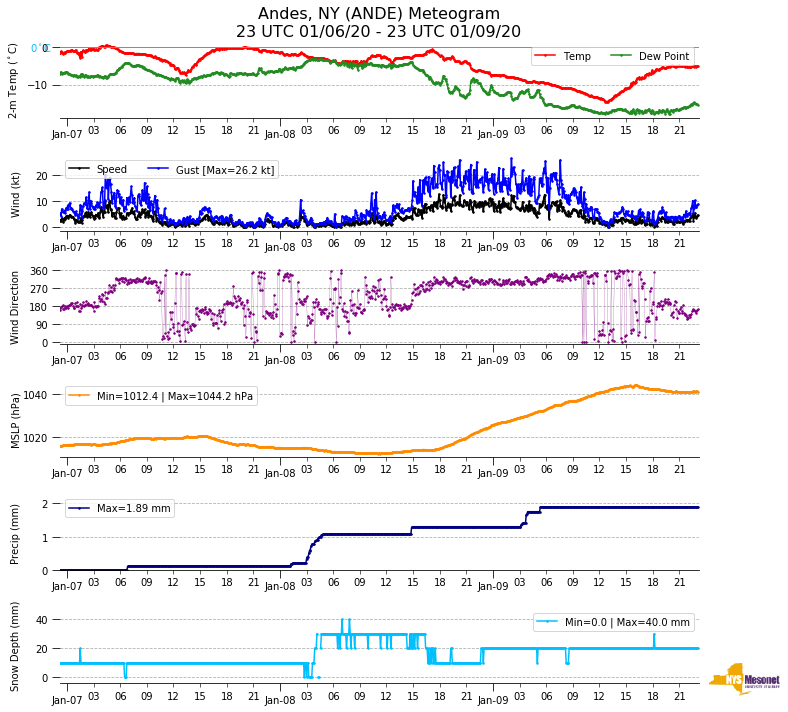

In [31]:
logo_path = '/home/disk/meso-home/jfinlon/impacts/mesonet/NYSM_logo_96x96.png'
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
plot_station_data(dt, time_start, time_end, data_3day, logo_path)